# Distributed Data

JuliaDB can distribute datasets across multiple processes and can even work with data larger than available memory (RAM).

First let's start by adding some worker Julia processes.  If you do not specify a number, `addprocs` will add as many workers as there are CPU cores available.

In [1]:
addprocs(2)

2-element Array{Int64,1}:
 2
 3

In [2]:
using JuliaDB

# print table rather than column summary
IndexedTables.set_show_compact!(false);

### When multiple processes are available, `loadtable` will create distributed tables. 

- Note the line above the column names printed below:
   
`Distributed Table with 56023 rows in 2 chunks`

In [3]:
dt = loadtable("stocksample", filenamecol = :Ticker, indexcols = [:Ticker, :Date])

Distributed Table with 56023 rows in 2 chunks:
Ticker         Date        Open     High     Low      Close    Volume     OpenInt
─────────────────────────────────────────────────────────────────────────────────
"aapl.us.txt"  1984-09-07  0.42388  0.42902  0.41874  0.42388  23220030   0
"aapl.us.txt"  1984-09-10  0.42388  0.42516  0.41366  0.42134  18022532   0
"aapl.us.txt"  1984-09-11  0.42516  0.43668  0.42516  0.42902  42498199   0
"aapl.us.txt"  1984-09-12  0.42902  0.43157  0.41618  0.41618  37125801   0
"aapl.us.txt"  1984-09-13  0.43927  0.44052  0.43927  0.43927  57822062   0
"aapl.us.txt"  1984-09-14  0.44052  0.45589  0.44052  0.44566  68847968   0
"aapl.us.txt"  1984-09-17  0.45718  0.46357  0.45718  0.45718  53755262   0
"aapl.us.txt"  1984-09-18  0.45718  0.46103  0.44052  0.44052  27136886   0
"aapl.us.txt"  1984-09-19  0.44052  0.44566  0.43157  0.43157  29641922   0
"aapl.us.txt"  1984-09-20  0.43286  0.43668  0.43286  0.43286  18453585   0
"aapl.us.txt"  1984-09-21  0.

### Notable difference 1: No `getindex`

In [4]:
# We are no longer able to get the row based on row number

dt[1]

LoadError: [91mMethodError: no method matching getindex(::JuliaDB.DNextTable{NamedTuples._NT_Ticker_Date_Open_High_Low_Close_Volume_OpenInt{String,Date,Float64,Float64,Float64,Float64,Int64,Int64},NamedTuples._NT_Ticker_Date{String,Date}}, ::Int64)[39m

### Notable difference 2: Not iterable

In [5]:
# Similarly, we're no longer allowed to iterate over the rows

for row in dt
    println(row)
end

LoadError: [91mMethodError: no method matching start(::JuliaDB.DNextTable{NamedTuples._NT_Ticker_Date_Open_High_Low_Close_Volume_OpenInt{String,Date,Float64,Float64,Float64,Float64,Int64,Int64},NamedTuples._NT_Ticker_Date{String,Date}})[0m
Closest candidates are:
  start([91m::SimpleVector[39m) at essentials.jl:258
  start([91m::Base.MethodList[39m) at reflection.jl:560
  start([91m::ExponentialBackOff[39m) at error.jl:107
  ...[39m

# Bring Distributed Table Into Master Process

- While not necessary for most operations, you may occasionally want to bring a dataset into the master process.
- This is accomplished with the `collect` function.
- Note that after `collect`ing, the header says `Table` instead of `Distributed Table`.

In [6]:
t = collect(dt)

Table with 56023 rows, 8 columns:
Ticker         Date        Open     High     Low      Close    Volume    OpenInt
────────────────────────────────────────────────────────────────────────────────
"aapl.us.txt"  1984-09-07  0.42388  0.42902  0.41874  0.42388  23220030  0
"aapl.us.txt"  1984-09-10  0.42388  0.42516  0.41366  0.42134  18022532  0
"aapl.us.txt"  1984-09-11  0.42516  0.43668  0.42516  0.42902  42498199  0
"aapl.us.txt"  1984-09-12  0.42902  0.43157  0.41618  0.41618  37125801  0
"aapl.us.txt"  1984-09-13  0.43927  0.44052  0.43927  0.43927  57822062  0
"aapl.us.txt"  1984-09-14  0.44052  0.45589  0.44052  0.44566  68847968  0
"aapl.us.txt"  1984-09-17  0.45718  0.46357  0.45718  0.45718  53755262  0
"aapl.us.txt"  1984-09-18  0.45718  0.46103  0.44052  0.44052  27136886  0
"aapl.us.txt"  1984-09-19  0.44052  0.44566  0.43157  0.43157  29641922  0
"aapl.us.txt"  1984-09-20  0.43286  0.43668  0.43286  0.43286  18453585  0
"aapl.us.txt"  1984-09-21  0.43286  0.44566  0.42388  

# Table Operations Still Work on a Distributed Table!

### Functions that return a single value still return a single value.

In [7]:
reduce(+, dt; select = :Close)

3.9113906713999943e6

### Functions that returned a Table now return a Distributed Table.

In [8]:
groupreduce(+, dt, :Ticker; select = :Close)

Distributed Table with 8 rows in 2 chunks:
Ticker          +
─────────────────────────
"aapl.us.txt"   1.86358e5
"amzn.us.txt"   9.36657e5
"dis.us.txt"    2.4894e5
"googl.us.txt"  1.29939e6
"ibm.us.txt"    6.82623e5
"msft.us.txt"   1.51555e5
"nflx.us.txt"   1.26508e5
"tsla.us.txt"   2.7936e5

### Functions that returned an `Array` now return a `DArray`.

In [9]:
select(dt, :Close)

Dagger.DArray{Float64,1,JuliaDB.##59#62}(56023,)

- Similar to tables, `collect` will change a `DArray` to an `Array`:

In [10]:
collect(select(dt, :Close))

56023-element Array{Float64,1}:
   0.42388
   0.42134
   0.42902
   0.41618
   0.43927
   0.44566
   0.45718
   0.44052
   0.43157
   0.43286
   0.42902
   0.42516
   0.41618
   ⋮      
 326.17   
 320.87   
 320.08   
 331.53   
 321.08   
 299.26   
 306.09   
 302.78   
 306.05   
 304.31   
 302.99   
 302.99   

# Out-of-Core Functionality

- Doc Reference: http://juliadb.org/latest/manual/out-of-core.html

### JuliaDB can be used to load/query datasets that are too big to fit in memory (RAM).

- The current out-of-core design is based around working with many files where each fits comfortably in memory.  
- In the future, JuliaDB will support individual files that are larger than memory.

#### Out-of-core support is restricted to `reduce`, `groupreduce`, and (a subset of) `join`

- Now let's pretend the stock data is much larger than it actually is and go through the steps of how to handle a larger-than-memory dataset.

### 1. Data is loaded into a distributed dataset in *chunks* that fit in memory

- A *chunk* contains the data from at least one file (one file cannot be split into multiple chunks).
- The `loadtable` and `loadndsparse` functions have the keyword arguments: 
  - `output`: Directory where the loaded data is written to an efficient binary format.
  - `chunks`: Number of parts to split the data into
- Data processing will occur on `number_of_files / chunks` files at a time.


- Here we load the stock data in 8 chunks (one file per chunk) into the output directory `bin`.

In [11]:
loadtable("stocksample", output = "bin", chunks=8, 
    filenamecol=:Ticker, indexcols=[:Ticker, :Date])

Distributed Table with 56023 rows in 8 chunks:
Ticker         Date        Open     High     Low      Close    Volume     OpenInt
─────────────────────────────────────────────────────────────────────────────────
"aapl.us.txt"  1984-09-07  0.42388  0.42902  0.41874  0.42388  23220030   0
"aapl.us.txt"  1984-09-10  0.42388  0.42516  0.41366  0.42134  18022532   0
"aapl.us.txt"  1984-09-11  0.42516  0.43668  0.42516  0.42902  42498199   0
"aapl.us.txt"  1984-09-12  0.42902  0.43157  0.41618  0.41618  37125801   0
"aapl.us.txt"  1984-09-13  0.43927  0.44052  0.43927  0.43927  57822062   0
"aapl.us.txt"  1984-09-14  0.44052  0.45589  0.44052  0.44566  68847968   0
"aapl.us.txt"  1984-09-17  0.45718  0.46357  0.45718  0.45718  53755262   0
"aapl.us.txt"  1984-09-18  0.45718  0.46103  0.44052  0.44052  27136886   0
"aapl.us.txt"  1984-09-19  0.44052  0.44566  0.43157  0.43157  29641922   0
"aapl.us.txt"  1984-09-20  0.43286  0.43668  0.43286  0.43286  18453585   0
"aapl.us.txt"  1984-09-21  0.

### 2. Data can then be `load`ed from the binary format

- `bintable` is now a distributed table made up of chunks that are on disk.

In [12]:
bintable = load("bin")

Distributed Table with 56023 rows in 8 chunks:
Ticker         Date        Open     High     Low      Close    Volume     OpenInt
─────────────────────────────────────────────────────────────────────────────────
"aapl.us.txt"  1984-09-07  0.42388  0.42902  0.41874  0.42388  23220030   0
"aapl.us.txt"  1984-09-10  0.42388  0.42516  0.41366  0.42134  18022532   0
"aapl.us.txt"  1984-09-11  0.42516  0.43668  0.42516  0.42902  42498199   0
"aapl.us.txt"  1984-09-12  0.42902  0.43157  0.41618  0.41618  37125801   0
"aapl.us.txt"  1984-09-13  0.43927  0.44052  0.43927  0.43927  57822062   0
"aapl.us.txt"  1984-09-14  0.44052  0.45589  0.44052  0.44566  68847968   0
"aapl.us.txt"  1984-09-17  0.45718  0.46357  0.45718  0.45718  53755262   0
"aapl.us.txt"  1984-09-18  0.45718  0.46103  0.44052  0.44052  27136886   0
"aapl.us.txt"  1984-09-19  0.44052  0.44566  0.43157  0.43157  29641922   0
"aapl.us.txt"  1984-09-20  0.43286  0.43668  0.43286  0.43286  18453585   0
"aapl.us.txt"  1984-09-21  0.

### 3. We can use out-of-core supported functions like usual

- When we call a function like `groupreduce`, each worker process will operate on one chunk at a time.

- You want to be sure that both `nprocs() * (size of chunks)` and the output of `reduce`/`groupreduce` fits in memory!

In [13]:
groupreduce(+, bintable, :Ticker; select = :Volume)

Distributed Table with 8 rows in 8 chunks:
Ticker          +
────────────────────────────
"aapl.us.txt"   891950579821
"amzn.us.txt"   40385735209
"dis.us.txt"    85815802336
"googl.us.txt"  26503128932
"ibm.us.txt"    81302723803
"msft.us.txt"   634313240042
"nflx.us.txt"   62518969374
"tsla.us.txt"   8205871633

# Plotting Big Data

- There are a few options for plotting JuliaDB datasets through the use of the Plots package.

## Plotting with StatPlots

- The StatPlots package allows you to plot a variety of tabular data structures, including those in JuliaDB.
- It gives you the entire power and flexibility of Plots, but **not for Distributed Tables**.

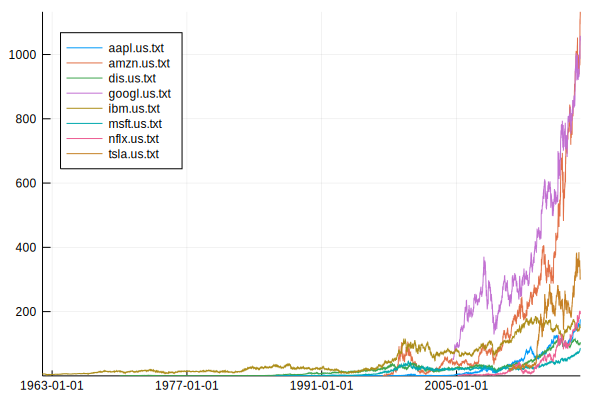

In [14]:
using StatPlots
gr()

@df collect(dt) plot(:Date, :Close; group=:Ticker, legend=:topleft)

## Plotting with `partitionplot`

- For large datasets, it may not be feasible to plot every point.  
- JuliaDB offers an alternative with `partitionplot`, which uses types in OnlineStats to incrementally build summaries of the data that can be plotted for datasets of **any** size.  
- The motivating idea is that the human brain cannot comprehend a huge number of points, so we can portray nearly the same information with summaries of the data rather than the data itself.


- The syntax for `partitionplot` is

  `partitionplot(table[, x], y; by, nparts = 100, stat = Extrema(), dropmissing = false)`

  where:

  - `x`, `y`, and `by` are selections
  - The number of summaries to be calculated are between `nparts` and `2 * nparts`
  - The type of summary is `stat`
  - Missing values are skipped if `dropmissing == true`
  - Any additional keyword arguments will be passed to Plots

- In the following example, we "recreate" the above plot by plotting the extrema (maximum and minimum) of the closing price over sections of time.

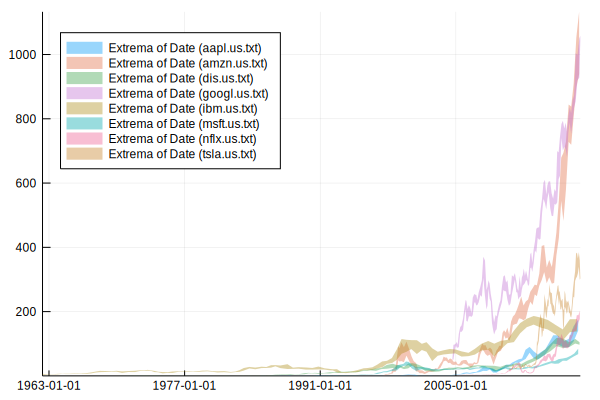

In [15]:
using OnlineStats

partitionplot(collect(bintable), :Date, :Close, by = :Ticker, nparts=100, stat = Extrema(),
    legend = :topleft)